In [70]:
from mllibrary.importer import dataset_uploader
from mllibrary.splitter import rolling_splitter
from mllibrary.fitter import *
from mllibrary.evaluator import *
from mllibrary.final_process import *

import warnings
warnings.filterwarnings("ignore")


# 1. Import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import time
import os
import gc
import bottleneck as bn
# Define Hyperparameters
T = 30

import xgboost as xgb

import tensorflow as tf
import keras

# detailed keras function import

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

import ray
ray.init()

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:42867 to respond...
Waiting for redis server at 127.0.0.1:55816 to respond...
Starting local scheduler with the following resources: {'CPU': 24, 'GPU': 1}.

View the web UI at http://localhost:8892/notebooks/ray_ui14601.ipynb?token=37769b2df90ac1a553a43aa55753dac0340aeb0ed175725a



{'node_ip_address': '192.168.1.36',
 'redis_address': '192.168.1.36:42867',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store39248223', manager_name='/tmp/plasma_manager30194528', manager_port=50472)],
 'local_scheduler_socket_names': ['/tmp/scheduler37786570'],
 'raylet_socket_names': [],
 'webui_url': 'http://localhost:8892/notebooks/ray_ui14601.ipynb?token=37769b2df90ac1a553a43aa55753dac0340aeb0ed175725a'}

In [2]:
x, y = dataset_uploader()


In [2]:
x = np.loadtxt('../../data/tick_ir.csv')


In [3]:
y = np.loadtxt('../../data/y.csv')

In [4]:
x.shape

(10, 43280000)

In [5]:
x = np.nan_to_num(x)

In [6]:
x = x.T

In [7]:
x_roll, y_roll, x__ = rolling_splitter(x, y)

(43280000, 10)
(43247540, 1)
in 0 th iteration:
(5410000, 1)
(5059240, 1)
(5059240, 10)
in 1 th iteration:
(5410000, 1)
(5117240, 1)
(5117240, 10)
in 2 th iteration:
(5410000, 1)
(5185920, 1)
(5185920, 10)
in 3 th iteration:
(5410000, 1)
(5244720, 1)
(5244720, 10)
in 4 th iteration:
(5410000, 1)
(5287280, 1)
(5287280, 10)
in 5 th iteration:
(5410000, 1)
(5341120, 1)
(5341120, 10)
in 6 th iteration:
(5410000, 1)
(5380160, 1)
(5380160, 10)
in 7 th iteration:
(5377540, 1)
(5361870, 1)
(5361870, 10)
The shape of total X is, (8,)
The shape of total y is, (8,)


In [8]:
gc.collect()

11

### 2. Fitting

Define several recorder and evaluation function

In [9]:
def matrix_extender(X, shape_zero = 40320, shape_one = 1829):
    print("Input matrix is a(an) %s" %type(X))
    # extend shape 1
    shape = np.shape(X)
    X = np.asarray(X)
    if shape[1] > shape_one:
        print('Error, input matrix have too much columns(shape[1]).')
        raise
    elif shape[0] > shape_zero:
        print('Error, input matrix have too much rows(shape[0].)')
        raise
        
    
    # start extending column(shape[1])
    if shape[1] < shape_one:
        delta_shape_one = shape_one - shape[1]
        nans = np.nan * np.zeros((int(shape[0]), int(delta_shape_one)))
        X = np.c_[X, nans]
        assert X.shape[1] == shape_one
    
    if shape[0] < shape_zero:
        assert X.shape[1] == shape_one
        delta_shape_zero = shape_zero - shape[0]
        nan = np.nan * np.zeros((int(delta_shape_zero), int(shape_one)))
        print(X.shape)
        print(nan.shape)
        X = np.r_[X, nan]
        assert X.shape[0] == shape_zero
    
    assert X.shape[0] == shape_zero
    assert X.shape[1] == shape_one
    
    print('Extension done.')
    
    return X 


In [10]:
'''
Clear content of all memories
'''
Method = []
MSE = []
RMSE = []
Time = []
y_hat = []
ic = []

In [11]:
# import X
price = np.memmap(r'../../quotes/stk_clsadj',dtype = np.float32, shape = (40000,1829))# ,shape = (204800, 1749))
price = matrix_extender(price)

Input matrix is a(an) <class 'numpy.core.memmap.memmap'>
(40000, 1829)
(320, 1829)
Extension done.


Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

y_hat_linear, acc1, acc2, acc3, time_ = fitting(linear, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('Linear')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)


model is LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007661
average value of IC is 0.692706
Total time used for fitting model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) is: 24.100538


In [13]:
y_hat_linear = matrix_extender(y_hat_linear)
simple_analysis(y_hat_linear, price)

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 120.97332382202148
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.072192
IR should be 1.129432
Sharpe Should be 107.138309


(0.07219198963101382,
 1.1294320378453102,
 107.13830901411518,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

ridge

In [14]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 0.2)

y_hat_ridge, acc1, acc2, acc3, time_ = fitting(ridge, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('ridge')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)


model is Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007661
average value of IC is 0.692706
Total time used for fitting model Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) is: 13.383832


In [15]:
y_hat_ridge= matrix_extender(y_hat_ridge)
simple_analysis(y_hat_ridge, price)

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 120.8271164894104
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.072192
IR should be 1.129428
Sharpe Should be 107.137896


(0.0721919329636798,
 1.1294281577947514,
 107.13789627451486,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

Random Forest Regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor
RFregression = RandomForestRegressor(max_features = 'log2',
                                     max_depth = 10,
                                     min_samples_split = 10,
                                     min_samples_leaf = 10,
                                     n_jobs = 10
                                    )

y_hat_RF, acc1, acc2, acc3, time_ = fitting(RFregression, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('Random Forest')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)

model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=10,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007658
average value of IC i

In [17]:
y_hat_RF= matrix_extender(y_hat_RF)
simple_analysis(y_hat_RF, price)

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 123.8239676952362
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.072918
IR should be 1.334622
Sharpe Should be 144.132920


(0.07291835797891691,
 1.33462182912057,
 144.13292042357457,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

Better RF

In [20]:
from sklearn.ensemble import RandomForestRegressor
RFregression_higher = RandomForestRegressor(max_features = 'log2',
                                     max_depth = 10,
                                     min_samples_split = 10,
                                     min_samples_leaf = 14,
                                     n_jobs = 25
                                    )

y_hat_RF1, acc1, acc2, acc3, time_ = fitting(RFregression_higher, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('Random Forest')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)

model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=14, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007657
average value of IC i

In [21]:
y_hat_RF1 = matrix_extender(y_hat_RF1)
simple_analysis(y_hat_RF1, price)

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 124.06905221939087
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.072832
IR should be 1.345779
Sharpe Should be 144.888184


(0.07283201935248837,
 1.3457794119318953,
 144.888183588964,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

Gradient Boosting Regressor

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
GBDT = GradientBoostingRegressor(n_estimators = 10,
                                subsample = 0.5,
                                min_samples_split = 10,
                                min_samples_leaf = 10,
                                max_features = 'log2',
                                alpha = 0.9)

y_hat_GBDT, acc1, acc2, acc3, time_ = fitting(GBDT, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('GBDT')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)


model is GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=10, presort='auto',
             random_state=None, subsample=0.5, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value 

In [19]:
y_hat_GBDT= matrix_extender(y_hat_GBDT)
simple_analysis(y_hat_GBDT, price)

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 124.43006992340088
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.071615
IR should be 1.153159
Sharpe Should be 100.638325


(0.07161498109148448,
 1.153158647662275,
 100.63832498254429,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
GBDT = GradientBoostingRegressor()

y_hat_GBDT1, acc1, acc2, acc3, time_ = fitting(GBDT, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('GBDT1')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)

model is GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
0 th iteration
10
5117240


KeyboardInterrupt: 

In [ ]:
y_hat_GBDT1= matrix_extender(y_hat_GBDT1)
simple_analysis(y_hat_GBDT1, price)

AdaBoost Regressor

In [23]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(n_estimators = 10)


y_hat_ada, acc1, acc2, acc3, time_ = fitting(ada, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('adaboost')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)


model is AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=10, random_state=None)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000075
average value of rmse is 0.008575
average value of IC is 0.126017
Total time used for fitting model AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=10, random_state=None) is: 1676.582993


In [24]:
y_hat_ada= matrix_extender(y_hat_ada)
simple_analysis(y_hat_ada, price)

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 109.7037718296051
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.042800
IR should be 0.694693
Sharpe Should be 35.618309


(0.042799686878344366,
 0.6946928898495424,
 35.61830940680644,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

Lasso

In [25]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.1)
y_hat_lasso, acc1, acc2, acc3, time_ = fitting(lasso, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('lasso')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)

model is Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007668
average value of IC is nan
Total time used for fitting model Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='c

In [26]:
y_hat_lasso= matrix_extender(y_hat_lasso)
simple_analysis(y_hat_lasso, price)

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 100.98603463172913
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.000000
IR should be 0.014169
Sharpe Should be nan


(1.6871149721098751e-18,
 0.014168959351894531,
 nan,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

Bayesian Ridge

In [27]:
from sklearn.linear_model import BayesianRidge
bridge = BayesianRidge()

y_hat_bridge, acc1, acc2, acc3, time_ = fitting(bridge, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('BayesianRidge')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)

model is BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007661
average value of IC is 0.692763
Total time used for fitting model BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_i

In [28]:
y_hat_bridge= matrix_extender(y_hat_bridge)
simple_analysis(y_hat_bridge, price)

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 122.06010961532593
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.072199
IR should be 1.129416
Sharpe Should be 106.996666


(0.07219943352543054,
 1.1294164520056071,
 106.99666645362957,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

In [67]:
y_hat_bridge.tofile('/home/hanhy/bayesian_ridge.bin')

Decision Tree Regressor

In [29]:
from sklearn.tree import DecisionTreeRegressor
DTregression = DecisionTreeRegressor(splitter = 'random',
                                    max_features = 'log2',
                                    max_depth = 10,
                                    min_samples_split = 10,
                                    min_samples_leaf = 10,
                                    )


y_hat_DT, acc1, acc2, acc3, time_ = fitting(DTregression, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('DecisionTree')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)

model is DecisionTreeRegressor(criterion='mse', max_depth=10, max_features='log2',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='random')
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007665
average value of IC is 0.568008
Total time used for fitting model DecisionTreeRegressor(

In [30]:
y_hat_DT= matrix_extender(y_hat_DT)
simple_analysis(y_hat_DT, price)

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 114.13191485404968
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.049617
IR should be 1.171334
Sharpe Should be 48.978258


(0.04961748736619185,
 1.1713340023566812,
 48.97825781616099,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

In [68]:
y_hat_DT.tofile('/home/hanhy/Decision_Tree.bin')

SVM

In [31]:
from sklearn.svm import SVR
svmregression = SVR(C=1.0, epsilon=0.2)

y_hat_SVM, acc1, acc2, acc3, time_ = fitting(svmregression, x_roll = x_roll, y_roll = y_roll, x__ = x__)


Method.append('SVM')
MSE.append(acc1)
RMSE.append(acc2)
ic.append(acc3)
Time.append(time_)

model is SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.002208
average value of rmse is 0.042832
average value of IC is nan
Total time used for fitting model SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) is: 988.226937


In [32]:
y_hat_SVM= matrix_extender(y_hat_SVM)
simple_analysis(y_hat_SVM, price)

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 121.05633425712585
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be -0.018343
IR should be -0.272609
Sharpe Should be -33.615834


(-0.018342911485955137,
 -0.27260859310035895,
 -33.615833977426,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

In [24]:
result

,ic,ir,sharpe
tick_ts0001.dat,0.022977,0.638560,110.847046
tick_ts0002.dat,0.023515,0.644204,108.508479
tick_ts0003.dat,0.021447,0.505994,104.659589
tick_ts0005.dat,0.054357,0.997351,114.472656
tick_ts0006.dat,0.058330,1.436391,154.268517
tick_ts0007.dat,0.035214,0.998893,133.221285
tick_ts0008.dat,0.059218,1.411181,59.156558
tick_ts0010.dat,0.058589,0.968106,91.411767
tick_ts0011.dat,0.051411,1.360746,151.777637
tick_ts0012.dat,0.056309,0.976709,116.360924


In [ ]:
param = {'max_depth': 2, 
         'eta': 1,
         'silent': 1,
         'objective': 'binary:logistic'
        }
bst = xgb.train(param, dtrain, num_round)

### 3. greedy search for optimized parameters

In [82]:
paras = [2,3,4,5,6,8 ,10, 12, 14, 16, 18, 20, 25, 30]
len(paras)

14

In [ ]:
paras = [2,3,4,5,6,8 ,10, 12, 14, 16, 18, 20, 25, 30, 40, 50]
len(paras)

In [35]:
paras[1]

3

In [36]:
for i in range(len(paras)):
    mleaf = paras[i]
    from sklearn.ensemble import RandomForestRegressor
    RFregression_higher = RandomForestRegressor(max_features = 'log2',
                                         max_depth = 5,
                                         min_samples_split = 10,
                                         min_samples_leaf = mleaf,
                                         n_jobs = 25
                                        )

    y_hat_RF1, acc1, acc2, acc3, time_ = fitting(RFregression_higher, x_roll = x_roll, y_roll = y_roll, x__ = x__)


    y_hat_RF1 = matrix_extender(y_hat_RF1)
    simple_analysis(y_hat_RF1, price)

model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240


KeyboardInterrupt: 

In [51]:
for i in range(len(paras)):
    msplit = paras[i]
    from sklearn.ensemble import RandomForestRegressor
    RFregression_higher = RandomForestRegressor(max_features = 'log2',
                                         max_depth = 5,
                                         min_samples_split = msplit,
                                         min_samples_leaf = 14,
                                         n_jobs = 25
                                        )

    y_hat_RF1, acc1, acc2, acc3, time_ = fitting(RFregression_higher, x_roll = x_roll, y_roll = y_roll, x__ = x__)


    y_hat_RF1 = matrix_extender(y_hat_RF1)
    simple_analysis(y_hat_RF1, price)

model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=14, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
11
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
11
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
11
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
11
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
11
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
11
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
11
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007658
average value of IC is 

the 5 th iteration. output shape is (5410000,1)
6 th iteration
11
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007657
average value of IC is 0.815109
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=14, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False) is: 134.799633
Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 127.87074685096741
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:

30734698
total time used for IC and LS matrix calculation is: 126.16106295585632
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.074693
IR should be 1.212558
Sharpe Should be 125.083127
model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=14, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
11
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
11
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
11
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
11
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
11
5341120
the 

the 1 th iteration. output shape is (5410000,1)
2 th iteration
11
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
11
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
11
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
11
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
11
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007658
average value of IC is 0.823200
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=14, min_samples_split=30,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False) is: 133.004117
Input matrix is a(an) <class 'numpy.ndarray'>
(4000

In [52]:
from sklearn.ensemble import RandomForestRegressor
RFregression_higher = RandomForestRegressor(max_features = 'log2',
                                     max_depth = 5,
                                     min_samples_split = 20,
                                     min_samples_leaf = 14,
                                     n_jobs = 25
                                    )

y_hat_RF1, acc1, acc2, acc3, time_ = fitting(RFregression_higher, x_roll = x_roll, y_roll = y_roll, x__ = x__)


y_hat_RF1 = matrix_extender(y_hat_RF1)
simple_analysis(y_hat_RF1, price)

model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=14, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
11
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
11
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
11
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
11
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
11
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
11
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
11
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007658
average value of IC is

(0.07492423239813273,
 1.2357126696748735,
 121.63386109135786,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

In [53]:
from sklearn.ensemble import RandomForestRegressor
RFregression_higher = RandomForestRegressor(max_features = 'log2',
                                     max_depth = 5,
                                     min_samples_split = 20,
                                     min_samples_leaf = 14,
                                     n_jobs = 25
                                    )

y_hat_RF1, acc1, acc2, acc3, time_ = fitting(RFregression_higher, x_roll = x_roll, y_roll = y_roll, x__ = x__)


y_hat_RF1 = matrix_extender(y_hat_RF1)
simple_analysis(y_hat_RF1, price)

model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=14, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
11
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
11
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
11
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
11
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
11
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
11
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
11
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007657
average value of IC is

(0.07531896139822754,
 1.2719121192441667,
 121.42914691715838,
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

In [38]:
from sklearn.ensemble import RandomForestRegressor

def greedy_search(paras, repeat_time):
    IC_ = []
    IR_ = []
    
    # for every parameters
    for i in range(len(paras)):
        msplit= paras[i]
        RFregression_higher = RandomForestRegressor(max_features = 'log2',
                                         max_depth = 10,
                                         min_samples_split = msplit,
                                         min_samples_leaf = 12,
                                         n_jobs = 25
                                        )
        if paras[i] < 9 or paras[i] > 20:
            repeat_time = 3
        for k in range(repeat_time):
            ic_ = []
            ir_ = []
            y_hat_RF1, acc1, acc2, acc3, time_ = fitting(RFregression_higher, x_roll = x_roll, y_roll = y_roll, x__ = x__)


            y_hat_RF1 = matrix_extender(y_hat_RF1)
            ic, ir, sharpe, array1, array2 = simple_analysis(y_hat_RF1, price)
            ic_.append(ic)
            ir_.append(ir)
        IC = np.mean(ic_)
        IR = np.mean(ir_)
        IC_.append(IC)
        IR_.append(IR)
    return IC_, IR_

In [39]:
IC, IR = greedy_search(paras, 5)

model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007658
average value of IC is

the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007660
average value of IC is 0.772281
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False) is: 224.521264
Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 125.43894743919373
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start

30734698
total time used for IC and LS matrix calculation is: 125.21060085296631
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.072780
IR should be 1.322014
Sharpe Should be 141.286472
model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 

the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007658
average value of IC is 0.768005
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False) is: 226.393460
Input matrix is a(an) <class 'numpy.ndarray'>
(4000

(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 129.00122475624084
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.072743
IR should be 1.335723
Sharpe Should be 143.512432
model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iter

the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007657
average value of IC is 0.787619
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_sta

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 128.46442294120789
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.072672
IR should be 1.355420
Sharpe Should be 143.901215
model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=16, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th it

the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007657
average value of IC is 0.793544
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=18, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_sta

(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 130.52638840675354
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.072817
IR should be 1.320692
Sharpe Should be 143.289109
model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iter

the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007656
average value of IC is 0.783627
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=30, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_sta

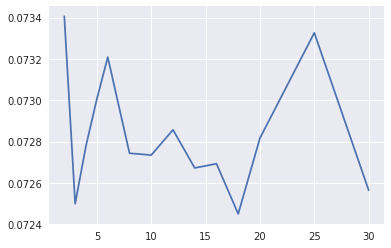

In [46]:
plt.plot(paras,IC)
plt.show()


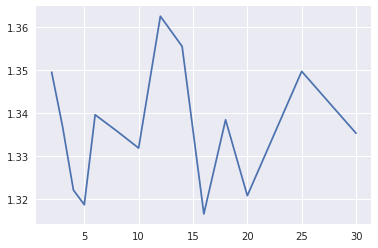

In [47]:
plt.plot(paras,IR)
plt.show()

In [68]:
from sklearn.ensemble import RandomForestRegressor

def greedy_search(paras, repeat_time):
    IC_ = []
    IR_ = []
    
    # for every parameters
    for i in range(len(paras)):
        mdepth= paras[i]
        RFregression_higher = RandomForestRegressor(max_features = 'log2',
                                         max_depth = mdepth,
                                         min_samples_split = 10,
                                         min_samples_leaf = 12,
                                         n_jobs = 25
                                        )
        if paras[i] < 9 or paras[i] > 20:
            repeat_time = 3
        for k in range(repeat_time):
            ic_ = []
            ir_ = []
            y_hat_RF1, acc1, acc2, acc3, time_ = fitting(RFregression_higher, x_roll = x_roll, y_roll = y_roll, x__ = x__)


            y_hat_RF1 = matrix_extender(y_hat_RF1)
            ic, ir, sharpe, array1, array2 = simple_analysis(y_hat_RF1, price)
            ic_.append(ic)
            ir_.append(ir)
        IC = np.mean(ic_)
        IR = np.mean(ir_)
        IC_.append(IC)
        IR_.append(IR)
    return IC_, IR_

In [69]:
IC_, IR = greedy_search(paras, 5)

model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007662
average value of IC is

the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007660
average value of IC is 0.821575
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False) is: 93.898715
Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 127.3473916053772
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:


30734698
total time used for IC and LS matrix calculation is: 128.62023663520813
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.072718
IR should be 1.187962
Sharpe Should be 118.947548
model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 

the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007656
average value of IC is 0.813657
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False) is: 150.373619
Input matrix is a(an) <class 'numpy.ndarray'>
(4000

(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 130.06055092811584
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.073625
IR should be 1.299241
Sharpe Should be 138.359783
model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iter

the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007662
average value of IC is 0.754569
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_sta

Input matrix is a(an) <class 'numpy.ndarray'>
(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 130.1570701599121
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.070896
IR should be 1.424341
Sharpe Should be 144.034774
model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th ite

the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000059
average value of rmse is 0.007674
average value of IC is 0.698526
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_sta

(40000, 1829)
(320, 1829)
Extension done.
Now Calculating IC and IR matrix, start counting...
30734698
total time used for IC and LS matrix calculation is: 146.0030074119568
IC_ should be: [nan nan nan ... nan nan nan]
LS_ should be: [nan nan nan ... nan nan nan]
Statistical factors evaluation start:
IC should be 0.067318
IR should be 1.388058
Sharpe Should be 132.838920
model is RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0 th iteration
10
5117240
the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th itera

the 0 th iteration. output shape is (10820000,1)
1 th iteration
10
5185920
the 1 th iteration. output shape is (5410000,1)
2 th iteration
10
5244720
the 2 th iteration. output shape is (5410000,1)
3 th iteration
10
5287280
the 3 th iteration. output shape is (5410000,1)
4 th iteration
10
5341120
the 4 th iteration. output shape is (5410000,1)
5 th iteration
10
5380160
the 5 th iteration. output shape is (5410000,1)
6 th iteration
10
5361870
the 6 th iteration. output shape is (5410000,1)
average value of mse is 0.000060
average value of rmse is 0.007716
average value of IC is 0.606548
Total time used for fitting model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=12, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=25,
           oob_score=False, random_state=None, verbose=0, warm_sta

In [49]:
Dict = {
    'parameters':np.asarray(paras),
    'IC':np.asarray(IC),
    'IR':np.asarray(IR)
    # 'y_hat':y_hat
    # dataframe
}
result = pd.DataFrame(Dict)


In [50]:
result

,parameters,IC,IR
0,2,0.073407,1.349414
1,3,0.072499,1.336805
2,4,0.072780,1.322014
3,5,0.073007,1.318596
4,6,0.073209,1.339506
5,8,0.072743,1.335723
6,10,0.072734,1.331763
7,12,0.072857,1.362423
8,14,0.072672,1.355420
9,16,0.072692,1.316456


In [62]:
Dict1 = {
    'parameters':np.asarray(paras),
    'IC':np.asarray(IC),
    'IR':np.asarray(IR)
    # 'y_hat':y_hat
    # dataframe
}
result1 = pd.DataFrame(Dict1)

In [63]:
result1

,parameters,IC,IR
0,2,<function IC at 0x7f93d1312730>,1.322879
1,3,<function IC at 0x7f93d1312730>,1.333954
2,4,<function IC at 0x7f93d1312730>,1.340286
3,5,<function IC at 0x7f93d1312730>,1.342515
4,6,<function IC at 0x7f93d1312730>,1.349726
5,8,<function IC at 0x7f93d1312730>,1.354210
6,10,<function IC at 0x7f93d1312730>,1.359676
7,12,<function IC at 0x7f93d1312730>,1.334047
8,14,<function IC at 0x7f93d1312730>,1.347677
9,16,<function IC at 0x7f93d1312730>,1.324504


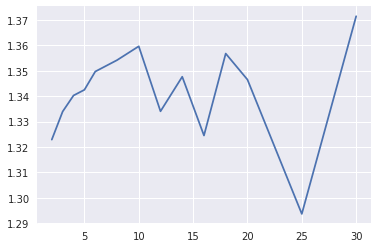

In [85]:
plt.plot(paras,result1['IR'])
plt.show()

In [75]:
Dict2 = {
    'parameters':np.asarray(paras),
    'IC':np.asarray(IC_),
    'IR':np.asarray(IR)
    # 'y_hat':y_hat
    # dataframe
}
result2 = pd.DataFrame(Dict2)

In [78]:
result2

,parameters,IC,IR
0,2,0.069669,1.159815
1,3,0.070904,1.163455
2,4,0.072718,1.187962
3,5,0.074824,1.233151
4,6,0.074916,1.249310
5,8,0.073625,1.299241
6,10,0.072773,1.323239
7,12,0.071533,1.370390
8,14,0.070896,1.424341
9,16,0.069457,1.430263


In [77]:
result2.to_csv('max_depth.csv')

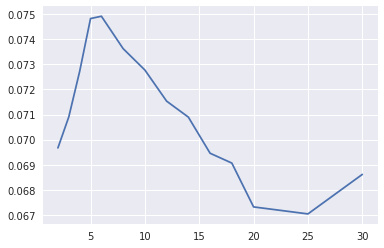

In [76]:
plt.plot(paras, IC_)
plt.show()

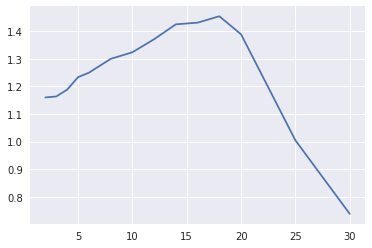

In [83]:
# plt.figure(figsize=(8,8))
plt.plot(paras, IR)
plt.show()